## Definições de projeto

In [1]:
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sqlalchemy.engine import Engine
from sqlalchemy import create_engine

base_path = "/media/bruno/Arquivos/Desenvolvimento/UBS"
load_dotenv(f"{base_path}/config/.env")

True

In [2]:
def get_engine() -> Engine:
    user = os.getenv("DB_USER")
    pw = os.getenv("DB_PASS")
    db = os.getenv("DB_NAME")
    host = os.getenv("DB_HOST")
    port = os.getenv("DB_PORT")
    return create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}")

## Início da análise

Uma hipótese inicial era de que a alocação de UBS se dava em função da população (Figura 2) e/ou PIB (Figura 3). Assim, SP deveria de apresentar uma quantidade absurdamente maior do que os demais estados, mas isto não é verificado na quantidade de UBS (Figura 1). Por outro lado, a quantidade de UBS parece ser mais relacionada com a quantidade de cidades (Figura 4), sobrepondo a influência do número de habitantes. Desse modo, alocar uma UBS por um estado não deve ser uma decisão puramente economômica.

Essa relação entre quantidade de cidades e quantidade de UBS fica mais visível pelo formato das distribuições, onde o decrescimento ocorre de maneira menos acentuada, quando comparada com as distribuições de PIB e população. Tal observação possui certa lógica, já que o objetivo do governo é alocar UBS nas cidades, estados com mais cidades deveriam de ter mais UBS.

Desta análise inicial, fica como observação uma possível menor relação entre população e quantidade de UBS. Para ratificar ou não a hipótese, a próxima abordagem faz a tradução de correlação em valores numéricos.

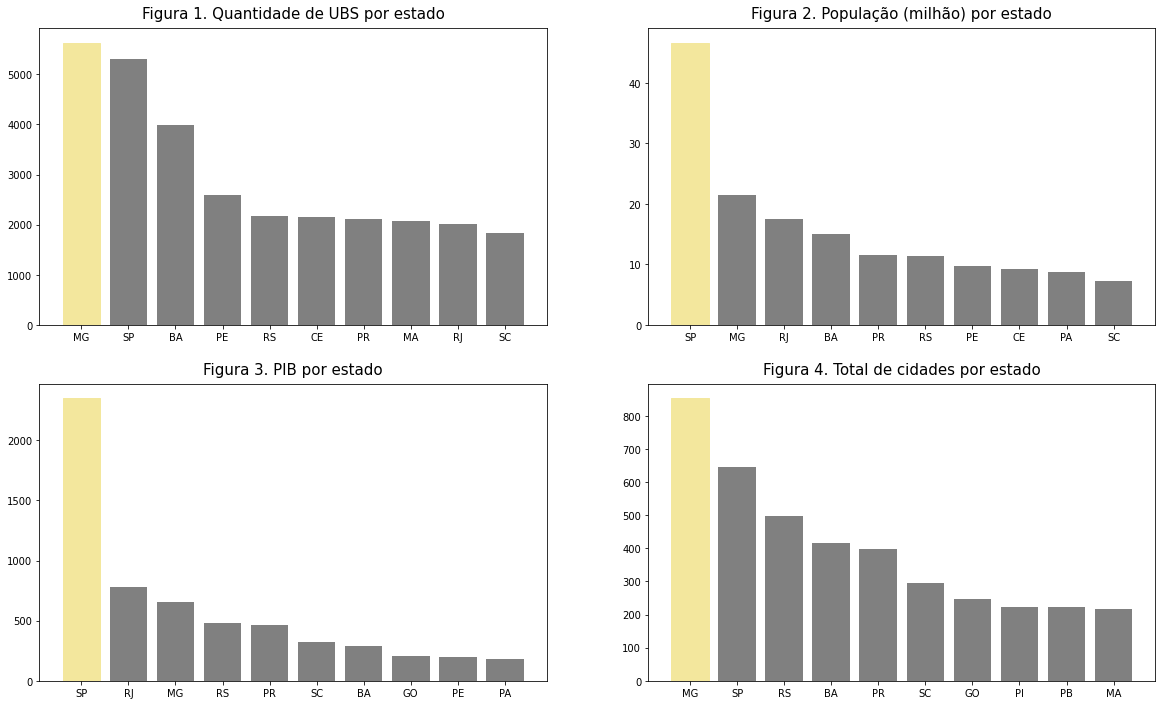

In [3]:
def view_distribution():
    engine = get_engine()
    with engine.connect() as connection:
        # Encontra o TOP10 de UBS por estado
        query = """
            select
                count(u.id) as total_ubs,
                s.symbol as state
            from ubs u, cities c, states s
            where u.city_id = c.id
                and s.id = c.state_id
                and s.symbol != 'DF'
            group by s.symbol
            order by total_ubs desc
            limit 10
        """
        ubs_by_state = pd.read_sql(query, connection)
        
        # Busca a quantidade de população por estado (por milhão)
        query = """
            select
                round(sum(c.population) / 1000000, 2) as population,
                s.symbol as state
            from cities c, states s
            where s.id = c.state_id and s.symbol != 'DF'
            group by s.symbol
            order by population desc
            limit 10
        """
        population_by_state = pd.read_sql(query, connection)

        # Busca o pib por estado (por bilhão, já no banco de dados)
        query = """
            select
                round(sum(c.pib_billion), 2) as pib,
                s.symbol as state
            from cities c, states s
            where s.id = c.state_id and s.symbol != 'DF'
            group by s.symbol
            order by pib desc
            limit 10
        """
        pib_by_state = pd.read_sql(query, connection)
        
        # Busca a quantidade de cidades por estado
        query = """
            select
                count(c.id) as cities,
                s.symbol as state
            from cities c, states s
            where s.id = c.state_id and s.symbol != 'DF'
            group by s.symbol
            order by cities desc
            limit 10
        """
        cities_by_state = pd.read_sql(query, connection)
        
        # Monta a estrutura para composição dos gráficos
        data = [
            {
                "values": ubs_by_state["total_ubs"].values,
                "categories": ubs_by_state["state"].values,
                "title": "Figura 1. Quantidade de UBS por estado",
                "row": 0, "column": 0
            },
            {
                "values": population_by_state["population"].values,
                "categories": population_by_state["state"].values,
                "title": "Figura 2. População (milhão) por estado",
                "row": 0, "column": 1
            },
            {
                "values": pib_by_state["pib"].values,
                "categories": pib_by_state["state"].values,
                "title": "Figura 3. PIB por estado",
                "row": 1, "column": 0
            },
            {
                "values": cities_by_state["cities"].values,
                "categories": cities_by_state["state"].values,
                "title": "Figura 4. Total de cidades por estado",
                "row": 1, "column": 1
            }
        ]

        # Faz o plot dos dados
        fig, ax = plt.subplots(2, 2, figsize=(20, 12))
        for reg in data:
            category_number = [j for j in range(len(reg["categories"]))]
            chart = ax[reg["row"]][reg["column"]].bar(category_number, reg["values"], color="#808080")
            ax[reg["row"]][reg["column"]].set_xticks(category_number, labels=reg["categories"], fontsize=10)
            ax[reg["row"]][reg["column"]].set_title(reg["title"], pad=10, fontdict={"fontsize": 15})
            chart[0].set_color("#f3e79d")
        
        plt.show()


view_distribution()

Duas abordagens podem ser realizadas para coeficiente de correlação, uma agrupando por cidade e outro agrupando por estado. A primeira entrega como resultado uma correlação forte entre população e total de UBS. Porém, cidades com maiores riquezas (PIB) também apresentam uma correlação positiva forte para a quantidade de UBS, uma relação não encontrada nos gráficos anteriores e nem na abordagem de agrupamento por estado. Dessa forma, podemos encontrar um indício de que a diferenciação de riqueza entre as cidades acaba afetando as médias. Em outras palavras, a desigualdade de riqueza nas cidades pode afetar a alocação de UBS.

Em todo caso, população continua sendo uma variável importante para explicar a alocação das UBS. Acrecenta-se no mapa de importância inicial também o PIB, sobretudo quando a análise for realizada a nível de cidade.

Para a distância média entre UBS e o centro da cidade, esperava-se que ela apresentasse uma relação com a área da cidade, afinal cidades maiores apresentam periferias mais distantes e, provavelmente, as unidades deveriam de estar mais espalhadas. Uma vez que a média sofre relação dos extremos, a distância média deveria de refletir essa tendência. Mas isto não foi observado, nem na abordagem de agrupamento por cidade e nem na abordagem de agrupamento por estado. Fica também um indício de que é possível que as periferias sofram com a alocação de UBS.

In [4]:
def show_correlation():
    engine = get_engine()
    with engine.connect() as connection:
        # Compila dados para correlação para as cidades. A distância entre a UBS
        # e o centro da cidade foi calculada por aproximação de trigonometria, uma
        # vez que as distâncias são pequenas e a curvatura da Terra não representa
        # um grande ofensor no resultado.
        query = """
            select
                count(u.id) as total_ubs,
                avg(c.population) as population,
                avg(c.pib_billion) as pib,
                avg(c.area) as area,
                avg(
                    sqrt(
                        power((c.latitude - u.latitude) * 60 * 1.852, 2)
                        + power((c.longitude - u.longitude) * 60 * 1.852, 2)
                    )
                ) as distance
            from ubs u, cities c, states s
            where u.city_id = c.id and c.state_id = s.id and s.symbol != 'DF'
            group by c.id
        """
        data_by_city = pd.read_sql(query, connection)
        print("VISUALIZAÇÃO DE CORRELAÇÃO DE DADOS ENTRE AS CIDADES")
        print(data_by_city.corr())

        # Compila dados para avaliação dos estados
        query = """
            select
                count(u.id) as total_ubs,
                sum(c.population) as population,
                sum(c.pib_billion) as pib,
                sum(c.area) as area,
                avg(
                    sqrt(
                        power((c.latitude - u.latitude) * 60 * 1.852, 2)
                        + power((c.longitude - u.longitude) * 60 * 1.852, 2)
                    )
                ) as distance
            from ubs u, cities c, states s
            where u.city_id = c.id and c.state_id = s.id and s.symbol != 'DF'
            group by s.id
        """
        data_by_state = pd.read_sql(query, connection)
        print("\nVISUALIZAÇÃO DE CORRELAÇÃO DE DADOS ENTRE OS ESTADOS")
        print(data_by_state.corr())


show_correlation()

VISUALIZAÇÃO DE CORRELAÇÃO DE DADOS ENTRE AS CIDADES
            total_ubs  population       pib      area  distance
total_ubs    1.000000    0.870458  0.797505  0.044357  0.085874
population   0.870458    1.000000  0.964120  0.017251  0.044118
pib          0.797505    0.964120  1.000000  0.004116  0.032556
area         0.044357    0.017251  0.004116  1.000000  0.182628
distance     0.085874    0.044118  0.032556  0.182628  1.000000

VISUALIZAÇÃO DE CORRELAÇÃO DE DADOS ENTRE OS ESTADOS
            total_ubs  population       pib      area  distance
total_ubs    1.000000    0.620235  0.577003  0.149994 -0.363228
population   0.620235    1.000000  0.996619  0.022679 -0.134031
pib          0.577003    0.996619  1.000000 -0.000694 -0.121991
area         0.149994    0.022679 -0.000694  1.000000  0.243713
distance    -0.363228   -0.134031 -0.121991  0.243713  1.000000


Para avaliar a cobertura das periferias, uma estratégia de aproximação foi utilizada. Considerando que cada cidade seja um círculo, é possível calcular o raio pela área. Posicionando as coordenadas do centro da cidade no centro da circunferência, a distância da UBS até o centro da cidade é também a distância até o centro do raio, portanto é possível calcular a porcentagem de afastamento da UBS em relação ao centro. Exemplificando, uma relação de 0 indica que a UBS está alocada no centro da cidade, enquanto uma relação de 1 indica que a UBS está alocada na divisa da cidade. Apesar de ser uma simplificação, cumpre o papel exploratório para responder a questão: quais estados atendem menos as periferias?

Utilizando um percentil de 80% da amostra (X), podemos definir que a grande maioria das UBS daquele estado distancia em X do centro. Em outras palavras, quanto mais próximo de 0, mais acumulada nos centros as UBS estão. Podemos identificar que as regiões norte e centro-oeste apresentam a maior concentração de UBS próximas ao centro, enquanto sudeste e nordeste atendem um pouco mais as periferias. O caso de maior abrangência é o ES, com uma relação de 0,57 para 80% das UBS. Ao criticar o número, podemos inferir que as áreas periféricas no Brasil sofrem com cobertura de unidades de saúde. Quando mais distante do centro, menor a probabilidade de existir uma UBS para atendimento.

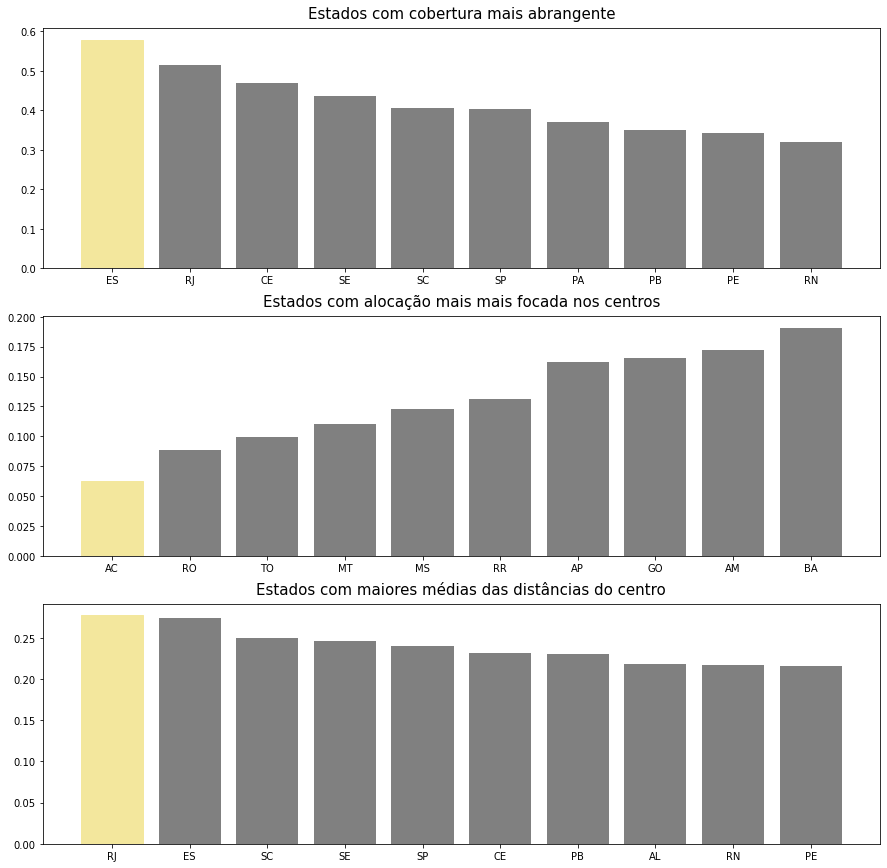

In [14]:
def analysis_distance():
    engine = get_engine()
    with engine.connect() as connection:
        # Compila dados de distância
        query = """
            select
                *,
                1 - (a.radio - a.distance) / a.radio as far_from_center
            from (
                select
                    u.city_id, s.symbol as state, c.area,
                    sqrt(c.area / pi()) as radio,
                    sqrt(
                        power((c.latitude - u.latitude) * 60 * 1.852, 2)
                        + power((c.longitude - u.longitude) * 60 * 1.852, 2)
                    ) as distance
                from ubs u, cities c, states s
                where u.city_id = c.id and c.state_id = s.id and s.symbol != 'DF'
                order by distance desc, area desc
            )a
            where a.distance <= a.radio
            order by far_from_center desc
        """
        distances = pd.read_sql(query, connection).dropna()
        
        # Exibe métricas descritivas para cada estado
        dataset = []
        for uf in distances["state"].unique():
            subset = distances.query(f"state == '{uf}'")
            dataset.append({
                "state": uf,
                "ubs_valids": len(subset),
                "min": np.min(subset["far_from_center"].values),
                "average": np.mean(subset["far_from_center"].values),
                "> 80%": np.percentile(subset["far_from_center"].values, 80),
                "max": np.max(subset["far_from_center"].values)
            })

        dataset = pd.DataFrame(dataset)

        # Compila os dados para exibição dos TOPs
        top = 10
        data = [{
            "position": 0,
            "title": "Estados com cobertura mais abrangente",
            "categories": dataset.sort_values("> 80%", ascending=False)["state"].values[:top],
            "values": dataset.sort_values("> 80%", ascending=False)["> 80%"].values[:top]
        }, {
            "position": 1,
            "title": "Estados com alocação mais mais focada nos centros",
            "categories": dataset.sort_values("> 80%", ascending=True)["state"].values[:top],
            "values": dataset.sort_values("> 80%", ascending=True)["> 80%"].values[:top]
        }, {
            "position": 2,
            "title": "Estados com maiores médias das distâncias do centro",
            "categories": dataset.sort_values("average", ascending=False)["state"].values[:top],
            "values": dataset.sort_values("average", ascending=False)["average"].values[:top]
        }]

        # Faz a exibição dos gráficos
        fig, ax = plt.subplots(len(data), 1, figsize=(15, 15))
        for reg in data:
            category_number = [j for j in range(len(reg["categories"]))]
            chart = ax[reg["position"]].bar(category_number, reg["values"], color="#808080")
            ax[reg["position"]].set_xticks(category_number, labels=reg["categories"], fontsize=10)
            ax[reg["position"]].set_title(reg["title"], pad=10, fontdict={"fontsize": 15})
            chart[0].set_color("#f3e79d")
        
        plt.show()


analysis_distance()